In [1]:
# add the path to the source code of the MonoForce package
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warp as wp
import torch

In [3]:
# intialize warp
wp.init()

Warp 1.0.2 initialized:
   CUDA Toolkit 11.5, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3070 Laptop GPU" (8 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/ruslan/.cache/warp/1.0.2


In [4]:
num_trajs = 100  # number of simulated trajectories (in parallel)
dt = 0.001  # simulation timestep
T = int(10.0 / dt)  # number of simulation timesteps to perform
device = "cuda" if torch.cuda.is_available() else "cpu"
grid_res = 0.1

In [5]:
# gaussian hm
x = np.linspace(-6.4, 6.4, 128)
y = np.linspace(-6.4, 6.4, 128)
X, Y = np.meshgrid(x, y)
hm = (1.0 * np.exp(-1.0 * ((X-0)**2 + (Y-4)**2)) +
      4.0 * np.exp(-5.0 * ((X-1)**2 + (Y+2)**2)) +
      2.0 * np.exp(-3.0 * ((X+2)**2 + (Y+4)**2))
      ) / 3.0

In [6]:
def vw_to_track_vel(v, w, r=1.0):
    # v: linear velocity, w: angular velocity, r: robot radius
    # v = (v_r + v_l) / 2
    # w = (v_r - v_l) / (2 * r)
    v_r = v + r * w
    v_l = v - r * w
    return v_r, v_l

In [7]:
np_hms = [hm for _ in range(num_trajs)]
res = [grid_res for _ in range(num_trajs)]

num_trajs = num_trajs + 1 if num_trajs % 2 == 1 else num_trajs
assert num_trajs % 2 == 0, 'num_trajs must be even'
vel_max, omega_max = 0.5, 0.5
vels = np.concatenate([-vel_max * np.ones((num_trajs // 2, T)), vel_max * np.ones((num_trajs // 2, T))])
omegas = np.concatenate([np.linspace(-omega_max, omega_max, num_trajs // 2),
                         np.linspace(-omega_max, omega_max, num_trajs // 2)])

track_vels = np.zeros((num_trajs, T, 2))
for i in range(num_trajs):
    track_vels[i, :, 0], track_vels[i, :, 1] = vw_to_track_vel(vels[i], omegas[i])
flipper_angles = np.zeros((num_trajs, T, 4))
# flipper_angles[0, :, 0] = 0.5

In [8]:
from monoforce.models.dphysics_warp import DiffSim

simulator = DiffSim(np_hms, res, T, use_renderer=False, device=device)
simulator.set_control(track_vels, flipper_angles)

Building simulation
Finalizing simulation
Warp DeprecationWarning: Support for built-in functions called with non-Warp array types, such as lists, tuples, NumPy arrays, and others, will be dropped in the future. Use a Warp type such as `wp.vec`, `wp.mat`, `wp.quat`, or `wp.transform`.
Simulation ready


In [9]:
from time import time

start = time()
body_q = simulator.simulate(render=False, use_graph=True if device == 'cuda' else False)
print('simulation took ', time() - start, ' s')
body_q_np = body_q.numpy()
forces_np = simulator.body_f.numpy()
print('body_q: ', body_q_np.shape)
print('forces: ', forces_np.shape)
assert body_q_np.shape == (T + 1, num_trajs, 7)
assert forces_np.shape == (T, num_trajs, 6)

Module warp.utils load on device 'cuda:0' took 4.31 ms
Module warp.sim.inertia load on device 'cuda:0' took 7.32 ms
Module warp.sim.model load on device 'cuda:0' took 0.76 ms
Module warp.sim.integrator load on device 'cuda:0' took 5.52 ms
Module warp.sim.collide load on device 'cuda:0' took 138.70 ms
Module warp.sim.particles load on device 'cuda:0' took 2.70 ms
Module warp.sim.utils load on device 'cuda:0' took 9.70 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 57.44 ms
Module warp.sim.articulation load on device 'cuda:0' took 32.64 ms
Module warp.sim.integrator_featherstone load on device 'cuda:0' took 65.23 ms
Module warp.sim.integrator_xpbd load on device 'cuda:0' took 105.52 ms
Module warp.render.utils load on device 'cuda:0' took 3.17 ms
Module warp.render.render_opengl load on device 'cuda:0' took 9.65 ms
Module warp.sim.render load on device 'cuda:0' took 1.65 ms
Module monoforce.models.dphysics_warp load on device 'cuda:0' took 583.15 ms
simulation took  2.0

In [10]:
# path with the smallest cost
# costs = np.linalg.norm(forces_np[..., :3], axis=-1).sum(axis=0)
costs = np.linalg.norm(forces_np[..., :3], axis=-1).sum(axis=0) + np.linalg.norm(forces_np[..., :3], axis=-1).std(axis=0)
path_lengths = np.sum(np.linalg.norm(np.diff(body_q_np[..., :3], axis=0), axis=2), axis=0)
assert costs.shape == (num_trajs,)
assert path_lengths.shape == (num_trajs,)
best_robot = np.argmin(costs)
num_trajs = body_q_np.shape[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


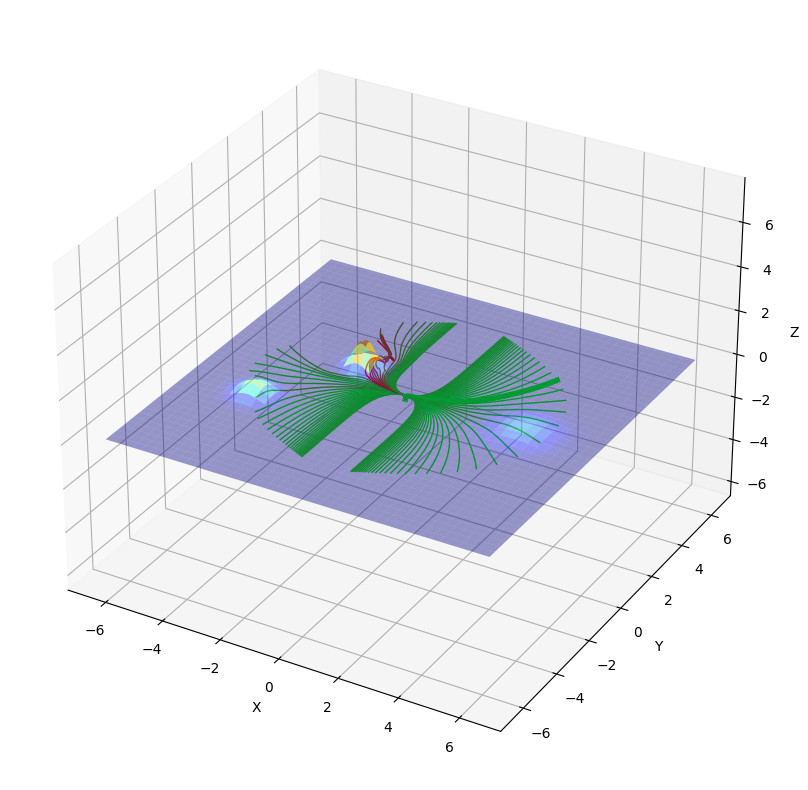

In [11]:
from monoforce.utils import normalize
from mpl_toolkits.mplot3d import Axes3D
from monoforce.vis import set_axes_equal

# show height map as a surface and best trajectory in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
hm_w, hm_h = hm.shape
X = np.linspace(-hm_w / 2. * grid_res, hm_w / 2. * grid_res, hm_w)
Y = np.linspace(-hm_h / 2. * grid_res, hm_h / 2. * grid_res, hm_h)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, hm.T, cmap='jet', alpha=0.4)
set_axes_equal(ax)
costs_norm = np.sqrt(normalize(costs))
colors = np.zeros((num_trajs, 3))
colors[:, 1] = 1 - costs_norm
colors[:, 0] = costs_norm
for i in range(num_trajs):
    marker = '-'
    linewidth = 1 if i != best_robot else 4
    ax.plot(body_q_np[:, i, 0], body_q_np[:, i, 1], body_q_np[:, i, 2], marker,
            linewidth=linewidth, color=colors[i])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()